In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import datetime
print(f"last edit: {datetime.datetime.now()}")

last edit: 2025-07-30 09:51:29.624800


In [3]:
!nvidia-smi

Wed Jul 30 09:51:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-07-30 09:51:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 172.253.118.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  21.8MB/s    in 8.5s    

2025-07-30 09:51:38 (18.9 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [5]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

there are 2 directories and 0 images in '10_food_classes_10_percent
there are 10 directories and 0 images in '10_food_classes_10_percent/train
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings
there are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice
there are 0 directories and 75 images in '10_food_classes_10_percent/train/steak
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream
there are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen
there are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza
there are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry
there are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi
there are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger
there are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon
there are

In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##**Setting up callback**

In [7]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##**Creating models using tensorflow Hub**

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Hub version: {hub.__version__}")

TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


In [11]:
## https://www.tensorflow.org/hub
## https://www.kaggle.com/models?tfhub-redirect=true&owner-type=organization&datatype=14102&task=16686
## https://github.com/paperswithcode

In [12]:
# Model URLs
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Define image shape (most TensorFlow Hub models expect 224x224)
IMAGE_SHAPE = (224, 224)

These URLs link to a saved pretrained model on TensorFlow Hub.

When we use them in our model, the model will automatically be downloaded for us to use.

To do this, we can use the [`KerasLayer()`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) model inside the TensorFlow hub library.

Since we're going to be comparing two models, to save ourselves code, we'll create a function `create_model()`. This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

The problem: **`error : Only instances of `keras.Layer` can be added to a Sequential model`** solve by two ways, I'm using way 2.

1. Try installing `tf_keras` by running `pip install tf_keras`. Then `import tf_keras` and and use `tf_keras.Sequential` instead of `tf.keras.Sequential` as shown below:
>

```
import tf_keras

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2
IMAGE_SHAPE = (224, 224)

classifier = tf_keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])
```

2. Recommended:
>

```
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0
```


> 🔑: [Full solution](https://stackoverflow.com/questions/78530756/error-only-instances-of-keras-layer-can-be-added-to-a-sequential-model)




In [13]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [14]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [15]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250730-095204
Epoch 1/5
24/24 [==============================] - 387s 16s/step - loss: 1.9567 - accuracy: 0.3640 - val_loss: 1.2188 - val_accuracy: 0.6108
Epoch 2/5
24/24 [==============================] - 406s 17s/step - loss: 0.8934 - accuracy: 0.7400 - val_loss: 0.8456 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - 350s 15s/step - loss: 0.6094 - accuracy: 0.8307 - val_loss: 0.7424 - val_accuracy: 0.7712
Epoch 4/5
24/24 [==============================] - 349s 15s/step - loss: 0.4746 - accuracy: 0.8840 - val_loss: 0.7080 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 405s 17s/step - loss: 0.3719 - accuracy: 0.9107 - val_loss: 0.6786 - val_accuracy: 0.7772


In [16]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

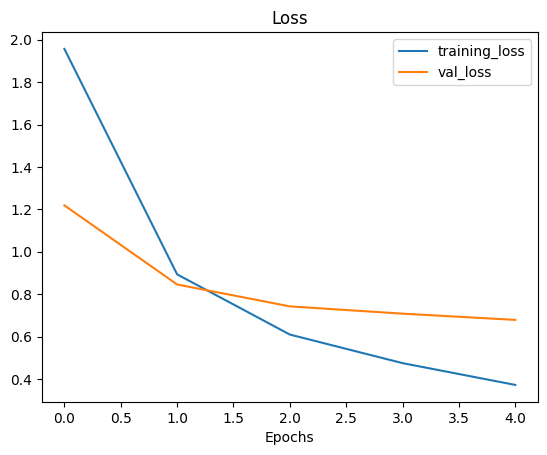

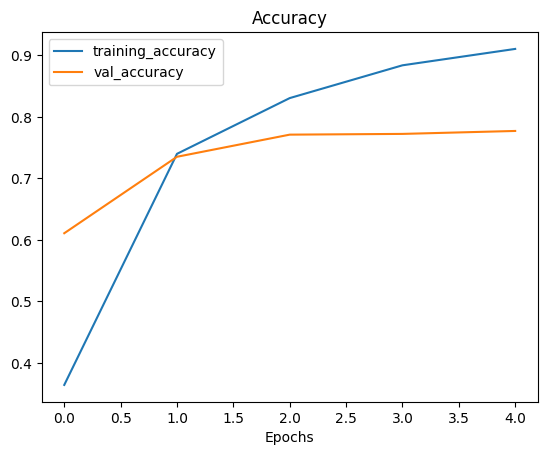

In [17]:
plot_loss_curves(resnet_history)

In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [19]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20250730-102536
Epoch 1/5
24/24 [==============================] - 216s 9s/step - loss: 1.8145 - accuracy: 0.4600 - val_loss: 1.2773 - val_accuracy: 0.7428
Epoch 2/5
24/24 [==============================] - 203s 9s/step - loss: 1.0354 - accuracy: 0.7867 - val_loss: 0.8465 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 203s 9s/step - loss: 0.7346 - accuracy: 0.8507 - val_loss: 0.6844 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 202s 9s/step - loss: 0.5888 - accuracy: 0.8827 - val_loss: 0.5992 - val_accuracy: 0.8552
Epoch 5/5
24/24 [==============================] - 205s 9s/step - loss: 0.5013 - accuracy: 0.8947 - val_loss: 0.5487 - val_accuracy: 0.8616


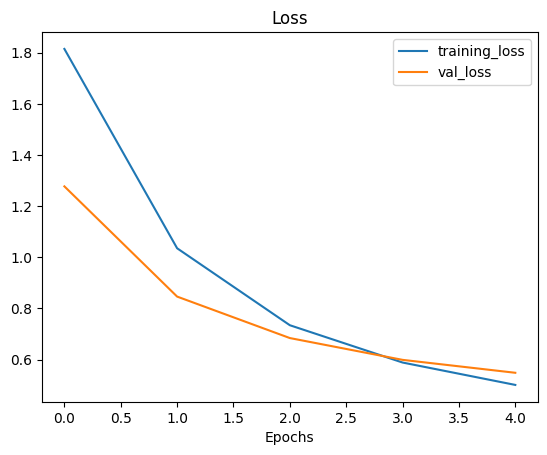

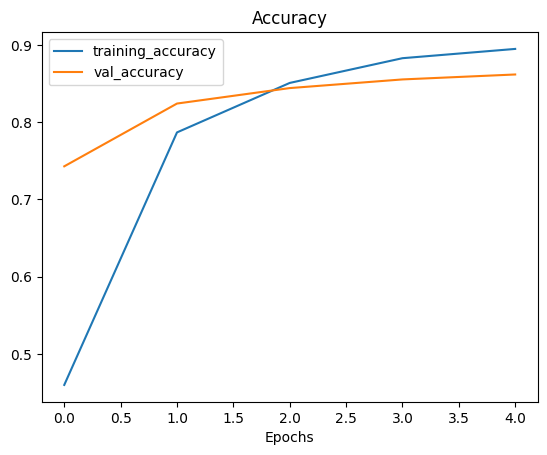

In [20]:
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


##**Comparing the models (Resnet_model & Efficientnet_model)**

In [24]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2025-07-30 10:52:00.998413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-30 10:52:00.998472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-30 10:52:00.999809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 10:52:02.127736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-07-30 10:52:03.677713: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

### Listing experiments you've saved to TensorBoard

To see all of the experiments you've uploaded you can use the command:

```tensorboard dev list```

In [25]:
!tensorboard dev list

2025-07-30 10:52:25.205613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-30 10:52:25.205667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-30 10:52:25.206969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 10:52:26.324729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-07-30 10:52:27.842535: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

In [27]:
# Install wandb
!pip install wandb

# Login to wandb (you'll need to create a free account at wandb.ai)
import wandb
wandb.login()

# Initialize wandb project
wandb.init(
    project="efficientnet-vs-resnet-comparison",
    name="EfficientNetB0 vs ResNet50V2",
    notes="Comparing two different TF Hub feature extraction models using 10% of training images"
)

# Method 1: Import existing TensorBoard logs
# First, let's check what's in your tensorboard directory
import os
print("TensorBoard log directories:")
for root, dirs, files in os.walk("./tensorflow_hub/"):
    for file in files:
        if file.endswith('.tfevents') or 'events.out.tfevents' in file:
            print(f"Found: {os.path.join(root, file)}")

# Import your existing logs - make sure to run this AFTER wandb.init()
wandb.init(
    project="efficientnet-vs-resnet-comparison",
    name="imported-tensorboard-logs"
)

# Sync TensorBoard logs to wandb
try:
    wandb.tensorboard.patch(root_logdir="./tensorflow_hub/")
    print("✅ TensorBoard logs imported successfully!")
except Exception as e:
    print(f"❌ Error importing logs: {e}")
    print("Make sure your TensorBoard logs exist in ./tensorflow_hub/")

wandb.finish()

# Method 2: Quick test with dummy data to verify wandb is working
wandb.init(
    project="efficientnet-vs-resnet-comparison",
    name="test-run"
)

# Log some test metrics to verify the connection
import numpy as np
for epoch in range(10):
    # Simulate training metrics
    acc = 0.5 + 0.3 * (1 - np.exp(-epoch/3)) + np.random.normal(0, 0.02)
    loss = 2.0 * np.exp(-epoch/3) + np.random.normal(0, 0.05)

    wandb.log({
        "epoch": epoch,
        "accuracy": acc,
        "loss": loss,
        "learning_rate": 0.001 * (0.9 ** epoch)
    })

print("✅ Test data logged!")
wandb.finish()
import tensorflow as tf

# Example training loop with wandb logging
def train_with_wandb(model, train_dataset, val_dataset, model_name):
    # Configure wandb to track this specific model
    config = wandb.config
    config.model_name = model_name
    config.learning_rate = 0.001
    config.batch_size = 32
    config.epochs = 10

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create wandb callback
    wandb_callback = wandb.keras.WandbCallback(
        monitor='val_accuracy',
        save_model=True,
        save_graph=True
    )

    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=config.epochs,
        callbacks=[wandb_callback]
    )

    return history

# Example usage for both models
# For EfficientNetB0
wandb.init(
    project="efficientnet-vs-resnet-comparison",
    name="EfficientNetB0-experiment",
    reinit=True
)
# train_with_wandb(efficientnet_model, train_ds, val_ds, "EfficientNetB0")
wandb.finish()

# For ResNet50V2
wandb.init(
    project="efficientnet-vs-resnet-comparison",
    name="ResNet50V2-experiment",
    reinit=True
)
# train_with_wandb(resnet_model, train_ds, val_ds, "ResNet50V2")
wandb.finish()

# Method 3: Log custom metrics and comparisons
wandb.init(
    project="efficientnet-vs-resnet-comparison",
    name="model-comparison-summary"
)

# Log comparison metrics
wandb.log({
    "EfficientNetB0/final_accuracy": 0.85,  # Replace with actual values
    "ResNet50V2/final_accuracy": 0.82,
    "EfficientNetB0/final_loss": 0.45,
    "ResNet50V2/final_loss": 0.52,
    "EfficientNetB0/params": 5288548,  # Model parameters
    "ResNet50V2/params": 25636712,
    "training_data_percentage": 10
})

# Create comparison table
comparison_table = wandb.Table(
    columns=["Model", "Accuracy", "Loss", "Parameters", "Training Time"],
    data=[
        ["EfficientNetB0", 0.85, 0.45, 5288548, "15 min"],
        ["ResNet50V2", 0.82, 0.52, 25636712, "25 min"]
    ]
)
wandb.log({"model_comparison": comparison_table})

# Log model artifacts (optional)
# wandb.save("efficientnet_model.h5")
# wandb.save("resnet_model.h5")

wandb.finish()

print("✅ Experiments logged to Weights & Biases!")
print("🔗 View your dashboard at: https://wandb.ai/")

TensorBoard log directories:
Found: ./tensorflow_hub/resnet50V2/20250730-095204/train/events.out.tfevents.1753869124.c23304e5cd02.1780.0.v2
Found: ./tensorflow_hub/resnet50V2/20250730-095204/validation/events.out.tfevents.1753869217.c23304e5cd02.1780.1.v2
Found: ./tensorflow_hub/efficientnetB0/20250730-102536/train/events.out.tfevents.1753871136.c23304e5cd02.1780.2.v2
Found: ./tensorflow_hub/efficientnetB0/20250730-102536/validation/events.out.tfevents.1753871195.c23304e5cd02.1780.3.v2


❌ Error importing logs: Tensorboard already patched. Call `wandb.tensorboard.unpatch()` first; remove `sync_tensorboard=True` from `wandb.init`; or only call `wandb.tensorboard.patch` once.
Make sure your TensorBoard logs exist in ./tensorflow_hub/


✅ Test data logged!


accuracy,▁▂▄▅▇▇▇█▇█
epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▆▅▄▃▃▂▁▁
loss,█▆▄▃▂▂▁▁▁▁
accuracy,0.78793
epoch,9
learning_rate,0.00039
loss,0.12442


EfficientNetB0/final_accuracy,▁
EfficientNetB0/final_loss,▁
EfficientNetB0/params,▁
ResNet50V2/final_accuracy,▁
ResNet50V2/final_loss,▁
ResNet50V2/params,▁
training_data_percentage,▁
EfficientNetB0/final_accuracy,0.85
EfficientNetB0/final_loss,0.45
EfficientNetB0/params,5288548
ResNet50V2/final_accuracy,0.82


✅ Experiments logged to Weights & Biases!
🔗 View your dashboard at: https://wandb.ai/
